In [64]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import os

data = 'balanced_05_vel05_pringles_amax_12_32/'
path = '/home/luiz/my_projects/crazyflie/crazyflie_controller/src/data/csv_data/' + data
save_image_path = '/home/luiz/my_projects/crazyflie/crazyflie_controller/src/data/images/' + data + 'velocity/'

save_flag = True
cut_data = True

if not os.path.exists(save_image_path):
    os.makedirs(save_image_path)

### CSV's available
# control_ref.csv
# control_sent.csv
# desired_position.csv
# desired_velocity.csv
# orientation_optitrack.csv
# pitch_roll_crazyflie.csv
# position_gaussian_error.csv
# position_kalman.csv
# position_optitrack.csv
# reference_vel.csv
# thrust_crazyflie.csv
# time.csv
# vel_crazyflie.csv
# vel_kalmam.csv
# vel_optitrack.csv
# yaw_angle_crazyflie.csv
# z_crazyflie.csv

# Load the data from CSV files
time = os.path.join(path, 'time.csv')

### Velocity
desired_velocity_path = os.path.join(path, 'desired_velocity.csv')
vel_optitrack_path = os.path.join(path, 'vel_optitrack.csv')
vel_kalman_path = os.path.join(path, 'vel_kalmam.csv')
vel_crazyflie_path = os.path.join(path, 'vel_crazyflie.csv')

### Orientation
orientation_optitrack_path = os.path.join(path, 'orientation_optitrack.csv')
yaw_angle_crazyflie_path = os.path.join(path, 'yaw_angle_crazyflie.csv')

# Load the data from CSV files
time = pd.read_csv(time)
desired_velocity = pd.read_csv(desired_velocity_path)
vel_optitrack = pd.read_csv(vel_optitrack_path)
vel_kalman = pd.read_csv(vel_kalman_path)
vel_crazyflie = pd.read_csv(vel_crazyflie_path)

orientation_optitrack = pd.read_csv(orientation_optitrack_path)
yaw_crazyflie = pd.read_csv(yaw_angle_crazyflie_path)

# Tranforming the data into numpy arrays
time = time.values
desired_velocity = desired_velocity.values
vel_optitrack_world= vel_optitrack.values
vel_kalman_body = vel_kalman.values
vel_crazyflie_world = vel_crazyflie.values
orientation_optitrack = orientation_optitrack.values
yaw_crazyflie = np.deg2rad(yaw_crazyflie.values)

### Limit the data to a specific time
if cut_data:
    start = 5
    end = 55

    len_time = len(time)
    max_time = time[len_time-1]

    start_index = int(start*len_time/max_time)
    end_index = int(end*len_time/max_time)

    time = np.array(time[start_index:end_index])
    desired_velocity = np.array(desired_velocity[start_index:end_index])
    vel_optitrack_world = np.array(vel_optitrack_world[start_index:end_index])
    vel_kalman_body = np.array(vel_kalman_body[start_index:end_index])
    vel_crazyflie_world = np.array(vel_crazyflie_world[start_index:end_index])
    orientation_optitrack = np.array(orientation_optitrack[start_index:end_index])
    yaw_crazyflie = np.array(yaw_crazyflie[start_index:end_index])

In [65]:
# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [66]:
def rotation_body_to_world(orientation, vector):
    R = np.array([[np.cos(orientation) , -np.sin(orientation)], 
                  [np.sin(orientation) , np.cos(orientation)]])
    return np.dot(R, vector)

def rotation_world_to_body(orientation, vector):
    R = np.array([[np.cos(orientation) , np.sin(orientation)], 
                  [-np.sin(orientation), np.cos(orientation)]])
    return np.dot(R, vector)

In [67]:
# ### Rotation matricies
# quaternion = [x, y, z, w]  # Replace these with your actual quaternion values

# # Create a rotation object from the quaternion
# rotation = R.from_quat(quaternion)

# # Convert the quaternion to Euler angles (in radians)
# euler_angles_radians = rotation.as_euler('xyz', degrees=False)
orientation_optitrack_rad = np.array([R.from_quat(orientation).as_euler('xyz', degrees=False) for orientation in orientation_optitrack])

vel_kalman_world = np.zeros((len(time), 3))
vel_optitrack_body = np.zeros((len(time), 3))
vel_crazyflie_body = np.zeros((len(time), 3))

for i in range(len(time)):
    vel_crazyflie_body[i, 0:2] = rotation_world_to_body(yaw_crazyflie[i,0], vel_crazyflie_world[i, 0:2])
    vel_crazyflie_body[i, 2] = vel_crazyflie_world[i, 2]

    vel_optitrack_body[i, 0:2] = rotation_world_to_body(orientation_optitrack_rad[i, 2], vel_optitrack_world[i, 0:2])
    vel_optitrack_body[i, 2] = vel_optitrack_world[i, 2]

    vel_kalman_world[i, 0:2] = rotation_body_to_world(yaw_crazyflie[i, 0], vel_kalman_body[i, 0:2])
    vel_kalman_world[i, 2] = vel_kalman_body[i, 2]

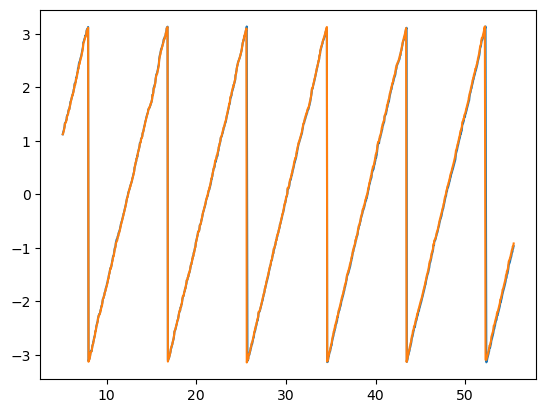

In [68]:
## orientation_optitrack_rad vs yaw_crazyflie

plt.plot(time, orientation_optitrack_rad[:, 2], label='optitrack')
plt.plot(time, yaw_crazyflie, label='crazyflie')


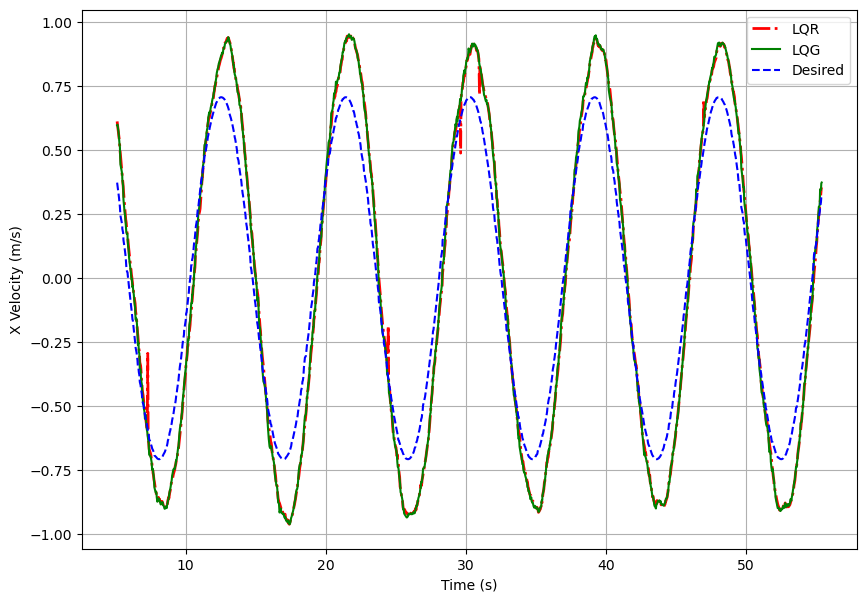

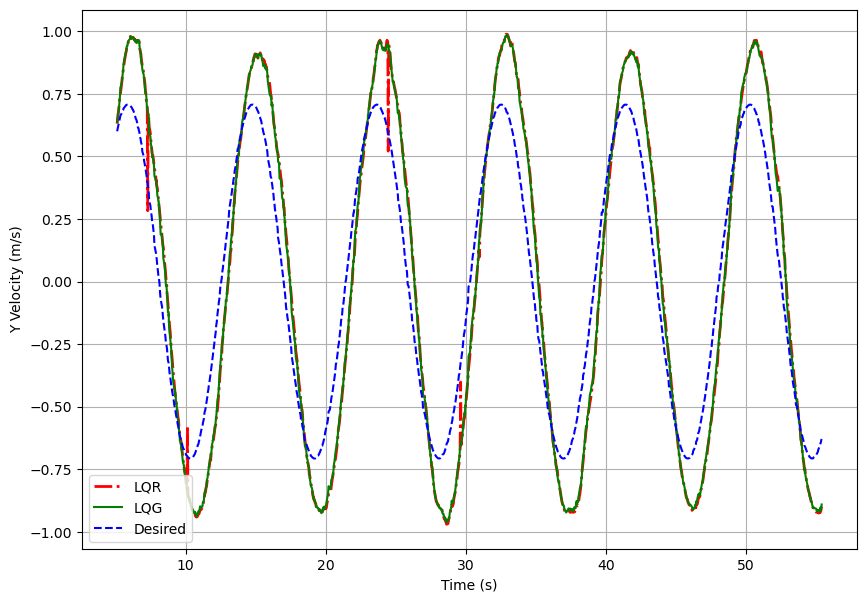

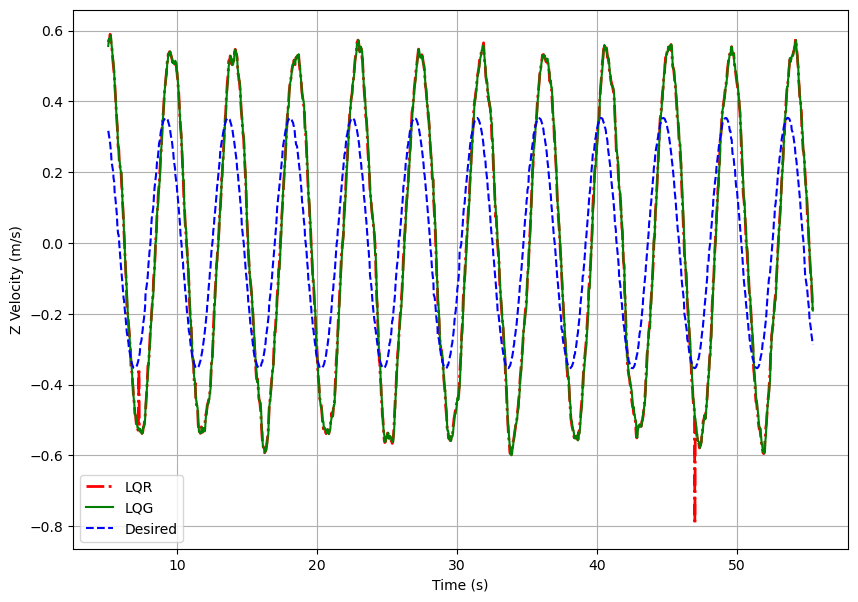

In [79]:
# X Dimension
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(time, vel_optitrack_world[:, 0], label='LQR', linestyle='-.', color='red', alpha=1, linewidth=2)
ax.plot(time, vel_kalman_world[:, 0], label='LQG', linestyle='-', color='green')
ax.plot(time, desired_velocity[:, 0], label='Desired', linestyle='--', color='blue')
ax.set_xlabel('Time (s)')
ax.set_ylabel('X Velocity (m/s)')
ax.legend()
ax.grid(True)

# Save the figure
if save_flag:
    fig.savefig(save_image_path + 'velocity_tracking_X.pdf')

# Y Dimension
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(time, vel_optitrack_world[:, 1], label='LQR', linestyle='-.', color='red', alpha=1, linewidth=2)
ax.plot(time, vel_kalman_world[:, 1], label='LQG', linestyle='-', color='green')
ax.plot(time, desired_velocity[:, 1], label='Desired', linestyle='--', color='blue')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Y Velocity (m/s)')
ax.legend()
ax.grid(True)

# Save the figure
if save_flag:
    fig.savefig(save_image_path + 'velocity_tracking_Y.pdf')


# Z Dimension
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(time, vel_optitrack_world[:, 2], label='LQR', linestyle='-.', color='red', alpha=1, linewidth=2)
ax.plot(time, vel_kalman_world[:, 2], label='LQG', linestyle='-', color='green')
ax.plot(time, desired_velocity[:, 2], label='Desired', linestyle='--', color='blue')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Z Velocity (m/s)')
ax.legend()
ax.grid(True)

# Save the figure
if save_flag:
    fig.savefig(save_image_path + 'velocity_tracking_Z.pdf', format='pdf')


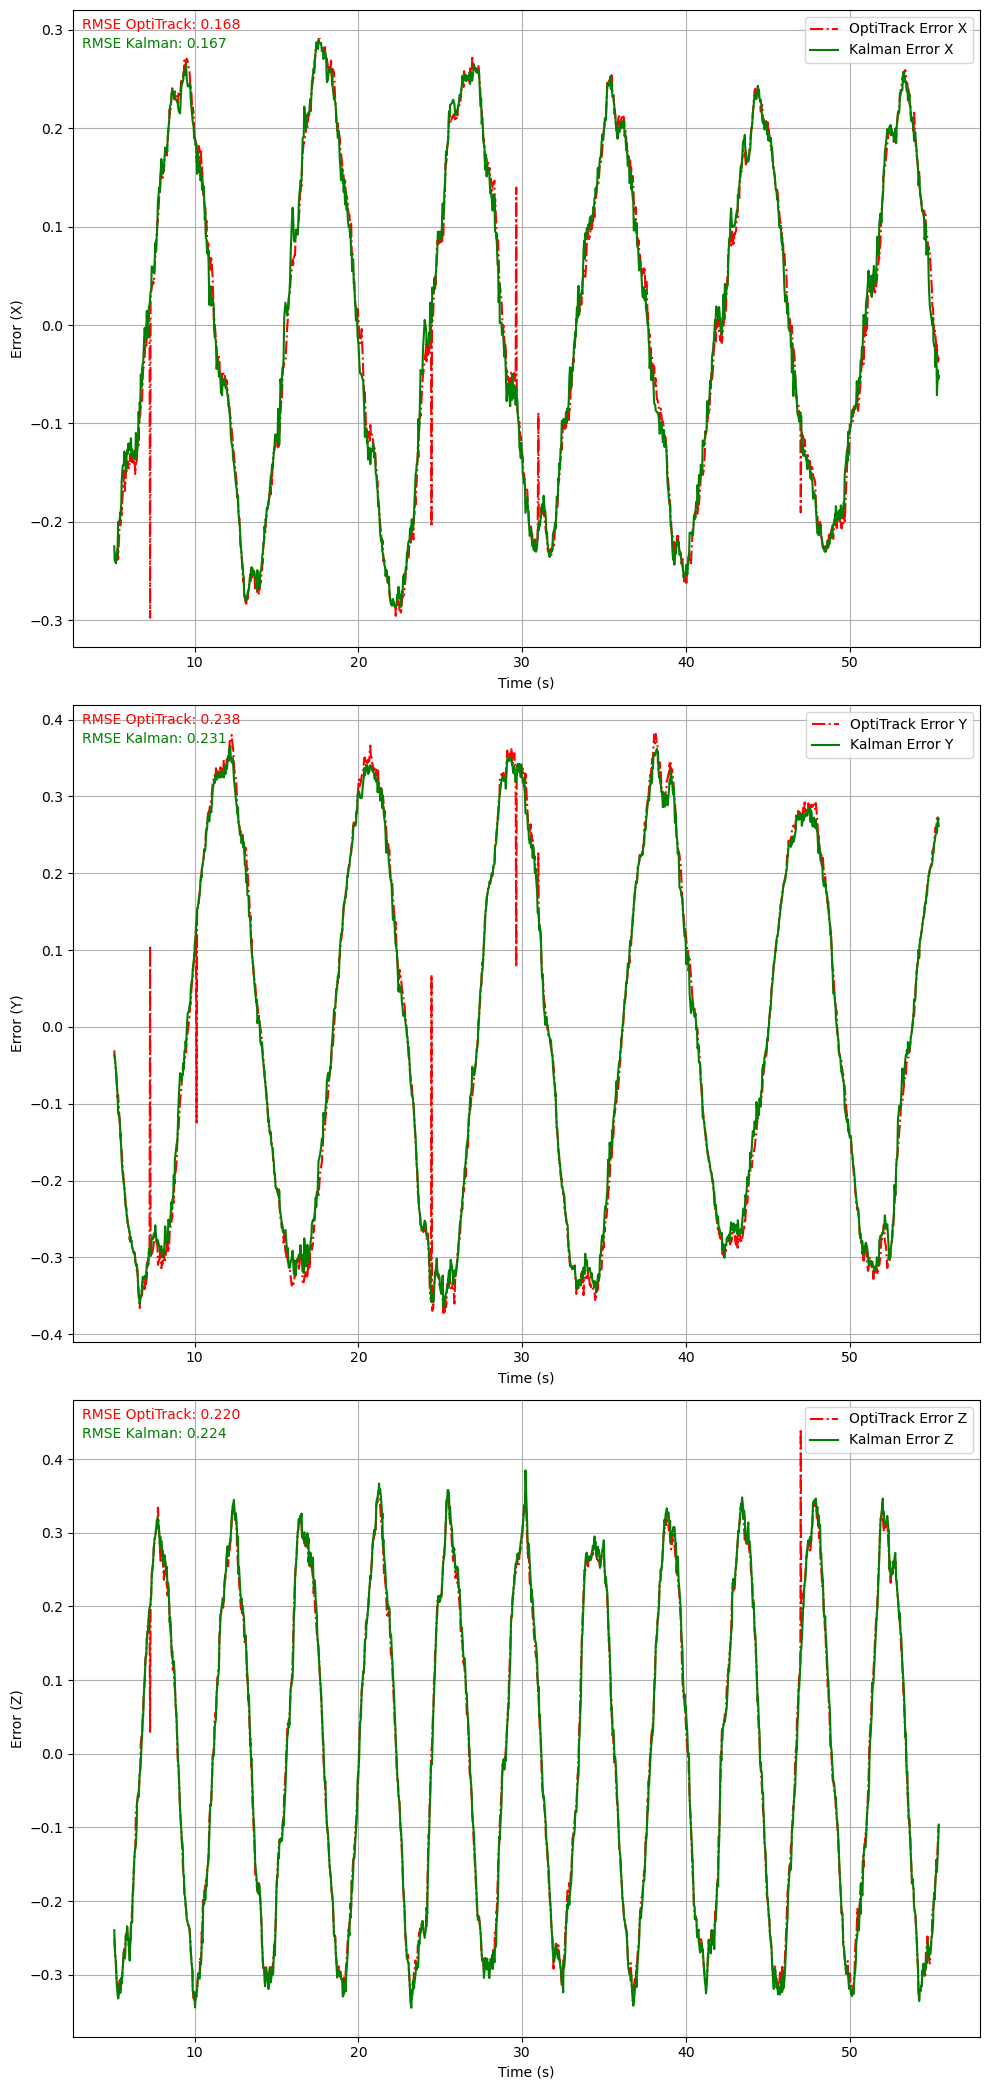

In [71]:
### Velocity error
# Calculating errors
error_kalman = desired_velocity - vel_kalman_world
error_optitrack = desired_velocity - vel_optitrack_world

# Calculating RMSE for each dimension
rmse_kalman = [calculate_rmse(desired_velocity[:, i], vel_kalman_world[:, i]) for i in range(3)]
rmse_optitrack = [calculate_rmse(desired_velocity[:, i], vel_optitrack_world[:, i]) for i in range(3)]

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 21))  # 3 rows, 1 column for X, Y, Z dimensions

dimensions = ['X', 'Y', 'Z']
for i in range(3):
    # Plotting the errors
    axs[i].plot(time, error_optitrack[:, i], label=f'OptiTrack Error {dimensions[i]}', linestyle='-.', color='red')
    axs[i].plot(time, error_kalman[:, i], label=f'Kalman Error {dimensions[i]}', linestyle='-', color='green')
    
    # Annotating RMSE on the plot
    axs[i].annotate(f'RMSE Kalman: {rmse_kalman[i]:.3f}', xy=(0.01, 0.94), xycoords='axes fraction', fontsize=10, color='green')
    axs[i].annotate(f'RMSE OptiTrack: {rmse_optitrack[i]:.3f}', xy=(0.01, 0.97), xycoords='axes fraction', fontsize=10, color='red')
    
    # axs[i].set_title(f'Velocity Error Comparison: Kalman and OptiTrack vs. Desired ({dimensions[i]} Dimension)')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel(f'Error ({dimensions[i]})')
    axs[i].grid(True)
    
    # Adjusting the legend location
    axs[i].legend(loc='upper right')

# Adjust layout to not overlap the subplots
plt.tight_layout()

# Assuming save_flag and save_image_path are defined
if save_flag:
    plt.savefig(os.path.join(save_image_path, 'velocity_error_comparison_rmse.pdf'), format='pdf')


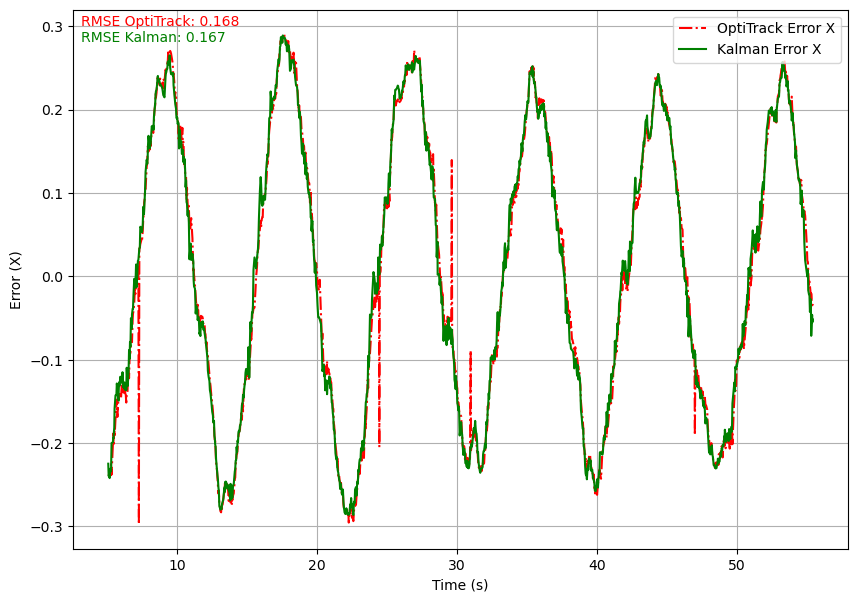

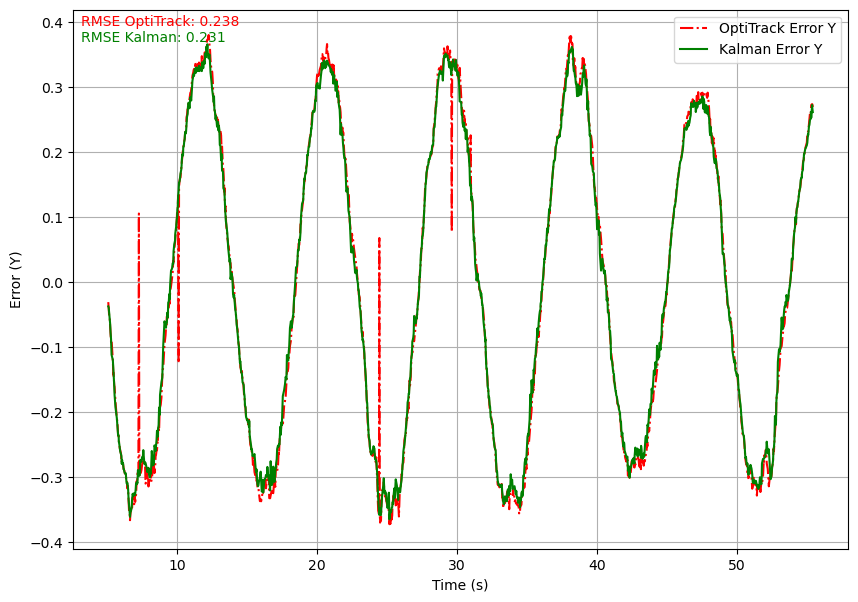

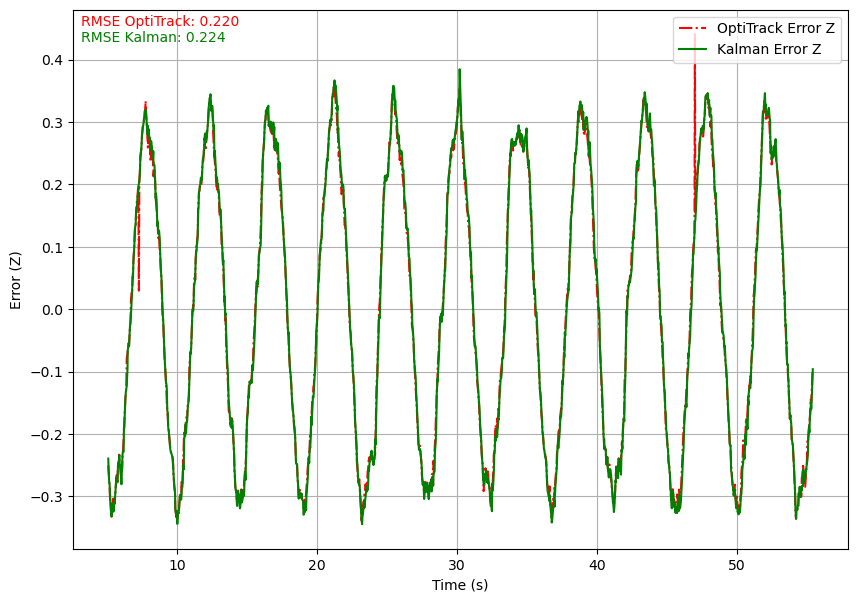

In [72]:
### Velocity error
# Calculating errors
error_kalman = desired_velocity - vel_kalman_world
error_optitrack = desired_velocity - vel_optitrack_world

# Calculating RMSE for each dimension
rmse_kalman = [calculate_rmse(desired_velocity[:, i], vel_kalman_world[:, i]) for i in range(3)]
rmse_optitrack = [calculate_rmse(desired_velocity[:, i], vel_optitrack_world[:, i]) for i in range(3)]

# Plotting and saving separately
for i in range(3):
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(time, error_optitrack[:, i], label=f'OptiTrack Error {dimensions[i]}', linestyle='-.', color='red')
    ax.plot(time, error_kalman[:, i], label=f'Kalman Error {dimensions[i]}', linestyle='-', color='green')
    ax.annotate(f'RMSE Kalman: {rmse_kalman[i]:.3f}', xy=(0.01, 0.94), xycoords='axes fraction', fontsize=10, color='green')
    ax.annotate(f'RMSE OptiTrack: {rmse_optitrack[i]:.3f}', xy=(0.01, 0.97), xycoords='axes fraction', fontsize=10, color='red')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(f'Error ({dimensions[i]})')
    ax.grid(True)
    ax.legend(loc='upper right')
    if save_flag:
        plt.savefig(os.path.join(save_image_path, f'velocity_error_{dimensions[i]}.pdf'), format='pdf')


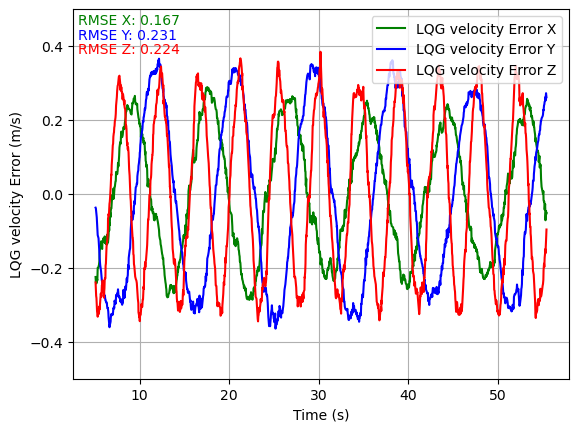

In [82]:
### Velocity error plot

# Calculate velocity errors
error_vel_kalman = desired_velocity - vel_kalman_world

# Plotting the error
plt.plot(time, error_vel_kalman[:, 0], label='LQG velocity Error X', linestyle='-', color='green')
plt.plot(time, error_vel_kalman[:, 1], label='LQG velocity Error Y', linestyle='-', color='blue')
plt.plot(time, error_vel_kalman[:, 2], label='LQG velocity Error Z', linestyle='-', color='red')

# Calculating RMSE for each dimension
# rmse_vel_kalman = [calculate_rmse(vel_optitrack_world[:, i], vel_kalman_world[:, i]) for i in range(3)]

# Calculating RMSE for each dimension manulally
rmse_kalman_x = np.sqrt(np.mean(error_vel_kalman[:, 0] ** 2))
rmse_kalman_y = np.sqrt(np.mean(error_vel_kalman[:, 1] ** 2))
rmse_kalman_z = np.sqrt(np.mean(error_vel_kalman[:, 2] ** 2))
rmse_vel_kalman = [rmse_kalman_x, rmse_kalman_y, rmse_kalman_z]

plt.annotate(f'RMSE X: {rmse_vel_kalman[0]:.3f}', xy=(0.01, 0.96), xycoords='axes fraction', fontsize=10, color='green')
plt.annotate(f'RMSE Y: {rmse_vel_kalman[1]:.3f}', xy=(0.01, 0.92), xycoords='axes fraction', fontsize=10, color='blue')
plt.annotate(f'RMSE Z: {rmse_vel_kalman[2]:.3f}', xy=(0.01, 0.88), xycoords='axes fraction', fontsize=10, color='red')

# Setting the title and labels
# plt.title('Kalman Velocity Error Comparison: OptiTrack vs. Kalman (XYZ Dimensions)')
plt.xlabel('Time (s)')
plt.ylabel('LQG velocity Error (m/s)')
plt.grid(True)
plt.legend(loc='upper right')
plt.ylim(-0.5, 0.5)

if save_flag:
    plt.savefig(os.path.join(save_image_path, 'LQG_velocity_error_xyz.pdf'), format='pdf')

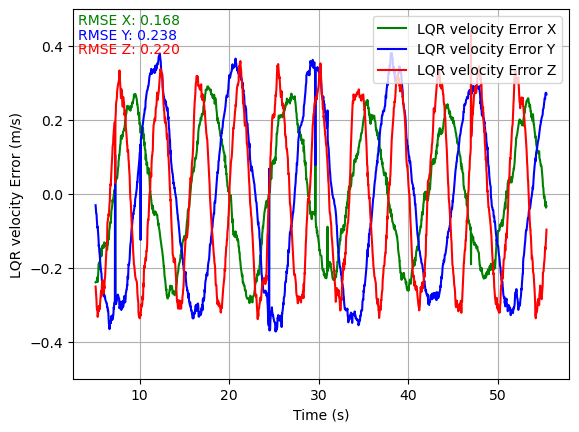

In [83]:
### Velocity error plot

# Calculate velocity errors
error_vel_kalman = desired_velocity - vel_optitrack_world

# Plotting the error
plt.plot(time, error_vel_kalman[:, 0], label='LQR velocity Error X', linestyle='-', color='green')
plt.plot(time, error_vel_kalman[:, 1], label='LQR velocity Error Y', linestyle='-', color='blue')
plt.plot(time, error_vel_kalman[:, 2], label='LQR velocity Error Z', linestyle='-', color='red')

# Calculating RMSE for each dimension
# rmse_vel_kalman = [calculate_rmse(vel_optitrack_world[:, i], vel_kalman_world[:, i]) for i in range(3)]

# Calculating RMSE for each dimension manulally
rmse_kalman_x = np.sqrt(np.mean(error_vel_kalman[:, 0] ** 2))
rmse_kalman_y = np.sqrt(np.mean(error_vel_kalman[:, 1] ** 2))
rmse_kalman_z = np.sqrt(np.mean(error_vel_kalman[:, 2] ** 2))
rmse_vel_kalman = [rmse_kalman_x, rmse_kalman_y, rmse_kalman_z]

plt.annotate(f'RMSE X: {rmse_vel_kalman[0]:.3f}', xy=(0.01, 0.96), xycoords='axes fraction', fontsize=10, color='green')
plt.annotate(f'RMSE Y: {rmse_vel_kalman[1]:.3f}', xy=(0.01, 0.92), xycoords='axes fraction', fontsize=10, color='blue')
plt.annotate(f'RMSE Z: {rmse_vel_kalman[2]:.3f}', xy=(0.01, 0.88), xycoords='axes fraction', fontsize=10, color='red')

# Setting the title and labels
# plt.title('Kalman Velocity Error Comparison: OptiTrack vs. Kalman (XYZ Dimensions)')
plt.xlabel('Time (s)')
plt.ylabel('LQR velocity Error (m/s)')
plt.grid(True)
plt.legend(loc='upper right')
plt.ylim(-0.5, 0.5)

if save_flag:
    plt.savefig(os.path.join(save_image_path, 'LQR_velocity_error_xyz.pdf'), format='pdf')

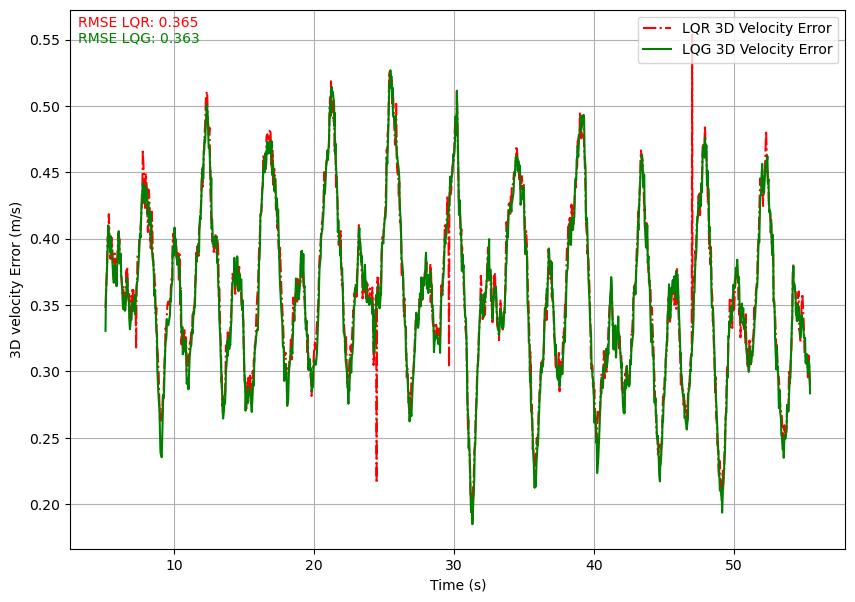

In [84]:
### 3D Velocity Error
# Calculating 3D error
error_kalman_3d = np.linalg.norm(error_kalman, axis=1)
error_optitrack_3d = np.linalg.norm(error_optitrack, axis=1)

# Calculating RMSE for 3D error MANUALLY

# RMSE for Kalman
rmse_kalman_3d = np.sqrt(np.mean(error_kalman_3d ** 2))

# RMSE for OptiTrack
rmse_optitrack_3d = np.sqrt(np.mean(error_optitrack_3d ** 2))

# Plotting
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(time, error_optitrack_3d, label='LQR 3D Velocity Error', linestyle='-.', color='red')
ax.plot(time, error_kalman_3d, label='LQG 3D Velocity Error', linestyle='-', color='green')
ax.annotate(f'RMSE LQR: {rmse_optitrack_3d:.3f}', xy=(0.01, 0.97), xycoords='axes fraction', fontsize=10, color='red')
ax.annotate(f'RMSE LQG: {rmse_kalman_3d:.3f}', xy=(0.01, 0.94), xycoords='axes fraction', fontsize=10, color='green')
ax.set_xlabel('Time (s)')
ax.set_ylabel('3D velocity Error (m/s)')
ax.grid(True)
ax.legend(loc='upper right')

# Save the figure
if save_flag:
    plt.savefig(os.path.join(save_image_path, 'velocity_error_3d.pdf'), format='pdf')

